In [1]:
%load_ext autoreload
%autoreload 2

# import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [2]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import uproot
from scipy.stats import iqr

from hepattn.experiments.clic.performance.performance import Performance
from hepattn.experiments.clic.performance.plot_helper_event import *
from hepattn.experiments.clic.performance.plot_helper_particle import *

In [3]:
save_dir = "/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/maskformer_infer_best"
SAVE_FIG = True

In [4]:
os.makedirs(save_dir, exist_ok=True)

In [5]:
net_dict = {
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFix_20250611-T181526/ckpts/epoch=172-val_loss=3.29018__test.root",
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test.root",
    # "mpflow":   "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test__common.root",
    "mpflow": "/share/gpu1/syw24/hepattn/logs/CLIC_Pflow_FullDiceFocFix_BF16_B64_20250625-T144653/ckpts/epoch=046-val_loss=1.07280__test.root",
    # "hgpflow": "/storage/agrp/nilotpal/HGPFlow_v2/experiments/hgpflow_v2/clicxminixbig1x2xs2xxxds7kirm1yo/inference/ee_qq_new/pred_test_p8_ee_qq_ecm380_20k_seg_bw0.3_nocut_merged.root",
    # 'hgpflow'
}

In [6]:
perf_obj = Performance(
    truth_path="/share/gpu1/syw24/dmitrii_clic/test_clic_common_raw.root",
    # truth_path="/share/gpu1/syw24/dmitrii_clic/test_clic_raw.root",
    networks=net_dict,
    # num_events=18000,
    # num_events={
    #     'mpflow' : 25_000,
    # }
)

E, pT will be scaled by 1


Reading truth tree...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.33it/s]


Number of events with at least one track or topocluster: 19998 out of 20000
[[ 1399]
 [11288]]
Number of events after filtering: 19998


Computing mpflow mass...: 100%|██████████████████████████████████████████████████████████████████████████| 24728/24728 [00:00<00:00, 26275.51it/s]


In [7]:
perf_obj.reorder_and_find_intersection()

common event count: 19779


Filtering and reordering mpflow...: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 646.49it/s]


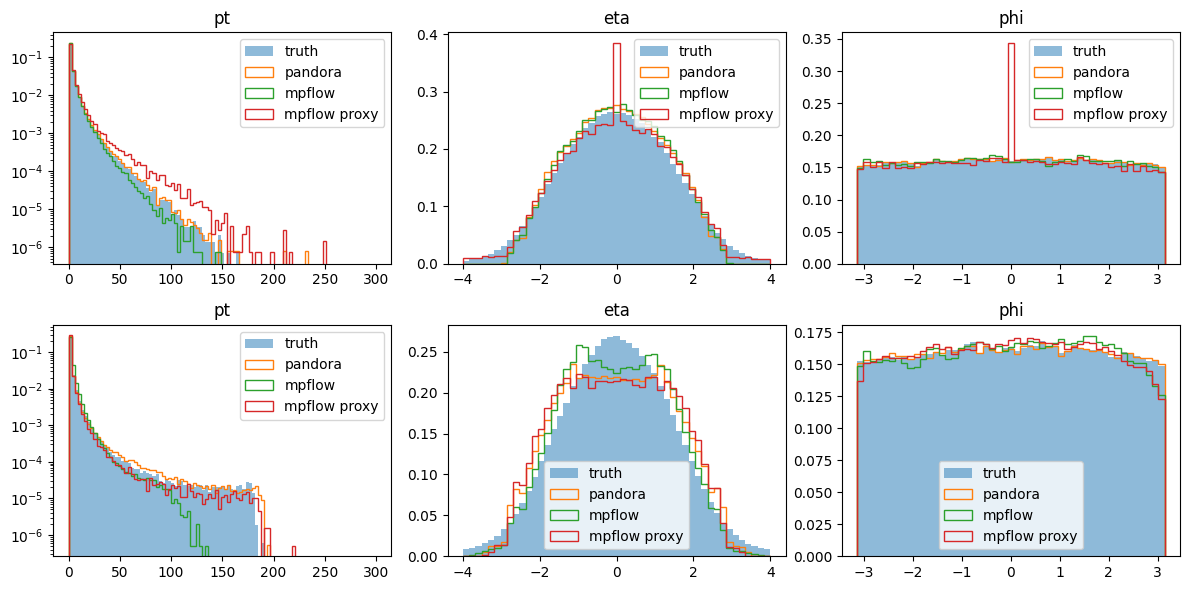

In [8]:
bins = [
    np.linspace(0, 300, 100),
    np.linspace(-4, 4, 50),
    np.linspace(-np.pi, np.pi, 50),
]
var_names = ["pt", "eta", "phi"]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
mask_fns = [
    lambda x: x < 3,
    lambda x: (x < 5) & (x > 2),
]
truth_class = np.concatenate(perf_obj.truth_dict["particle_class"])
pandora_class = np.concatenate(perf_obj.truth_dict["pandora_class"])

for i in range(3):
    for j in range(2):
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["particle_" + var_names[i]])[mask_fns[j](truth_class)],
            bins=bins[i],
            histtype="stepfilled",
            alpha=0.5,
            label="truth",
            density=True,
        )
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["pandora_" + var_names[i]])[mask_fns[j](pandora_class)],
            bins=bins[i],
            histtype="step",
            label="pandora",
            density=True,
        )
        for key, value in perf_obj.data.items():
            pf_class = np.concatenate(value["class"])
            ax[j, i].hist(
                np.concatenate(value[var_names[i]])[mask_fns[j](pf_class)],
                bins=bins[i],
                histtype="step",
                label=key,
                density=True,
            )
            if key in {"hgpflow", "mpflow"}:
                ax[j, i].hist(
                    np.concatenate(value["proxy_" + var_names[i]])[mask_fns[j](pf_class)],
                    bins=bins[i],
                    histtype="step",
                    label=key + " proxy",
                    density=True,
                )
        ax[j, i].set_title(var_names[i])
        ax[j, i].legend()
        ax[j, 0].set_yscale("log")

plt.tight_layout()
plt.show()

In [9]:
def get_n_particles(data_dict, key="class"):
    n_charged = []
    n_neutral = []
    for i in range(len(data_dict[key])):
        ch_mask = data_dict[key][i] <= 2
        n_charged.append(np.sum(ch_mask))
        n_neutral.append(np.sum(~ch_mask))
    return np.array(n_charged), np.array(n_neutral)

In [10]:
n_charged_truth, n_neutral_truth = get_n_particles(perf_obj.truth_dict, key="particle_class")
n_charged_pandora, n_neutral_pandora = get_n_particles(perf_obj.truth_dict, key="pandora_class")

for key in perf_obj.data.keys():
    n_charged, n_neutral = get_n_particles(perf_obj.data[key])
    perf_obj.data[key]["n_charged"] = n_charged
    perf_obj.data[key]["n_neutral"] = n_neutral

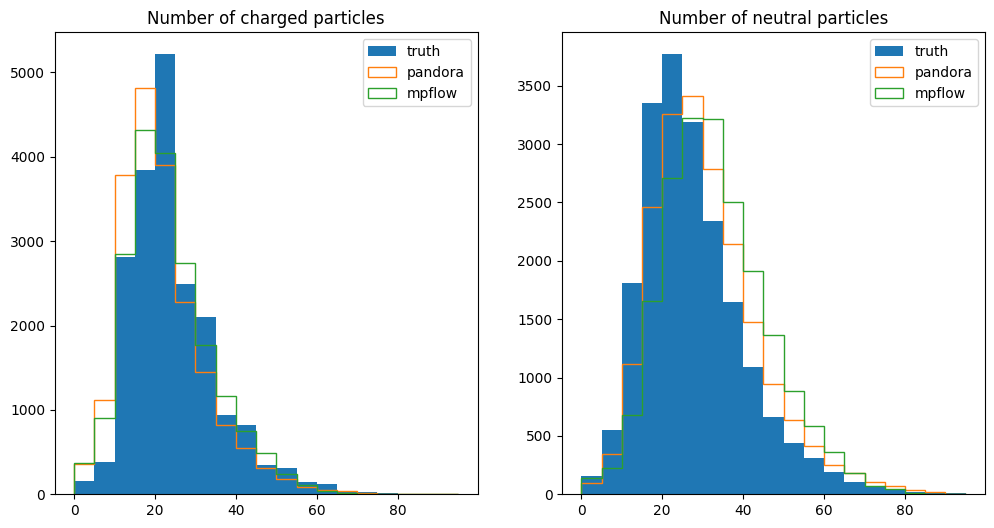

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(n_charged_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[1].hist(n_neutral_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[0].hist(n_charged_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
ax[1].hist(n_neutral_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    ax[0].hist(n_charged, bins=np.arange(0, 100, 5), histtype="step", label=key)
    ax[1].hist(n_neutral, bins=np.arange(0, 100, 5), histtype="step", label=key)
ax[0].legend()
ax[1].legend()
ax[0].set_title("Number of charged particles")
ax[1].set_title("Number of neutral particles")
plt.show()

In [12]:
def _add_hist(ax, data, bins, label, histtype="step", **kwargs):
    mean, iqr_ = np.mean(data), iqr(data)
    label = rf"{label}: $\mu$={mean:.2f}, iqr={iqr_:.2f}"
    ax.hist(data, bins=bins, histtype=histtype, label=label, **kwargs)

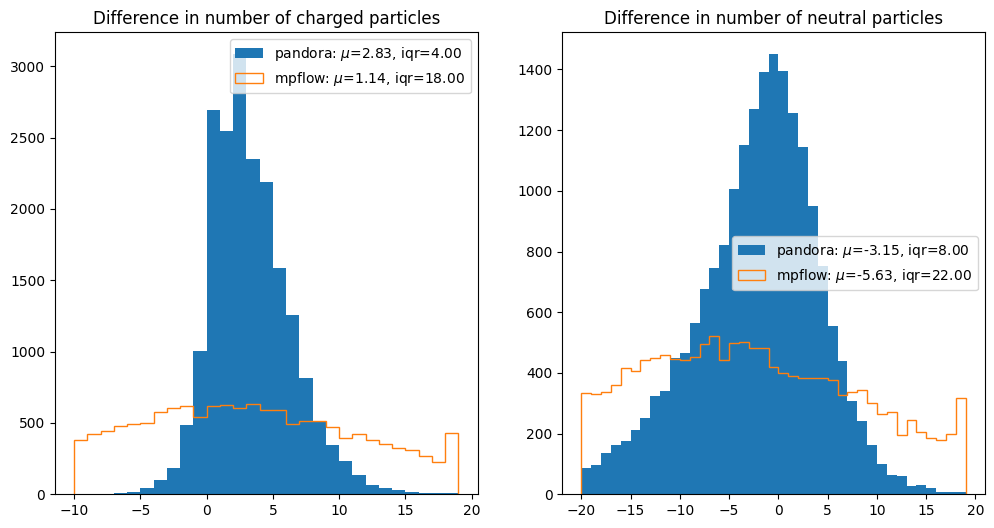

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
_add_hist(ax[0], n_charged_truth - n_charged_pandora, bins=np.arange(-10, 20, 1), histtype="stepfilled", label="pandora")
_add_hist(ax[1], n_neutral_truth - n_neutral_pandora, bins=np.arange(-20, 20, 1), histtype="stepfilled", label="pandora")
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    _add_hist(ax[0], n_charged_truth - n_charged, bins=np.arange(-10, 20, 1), label=key, histtype="step")
    _add_hist(ax[1], n_neutral_truth - n_neutral, bins=np.arange(-20, 20, 1), label=key, histtype="step")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Difference in number of charged particles")
ax[1].set_title("Difference in number of neutral particles")
plt.show()

(array([ 270.,  717., 3314., 5403., 4585., 2670., 1482.,  779.,  443.,
         116.]),
 array([  0. ,  13.1,  26.2,  39.3,  52.4,  65.5,  78.6,  91.7, 104.8,
        117.9, 131. ]),
 <BarContainer object of 10 artists>)

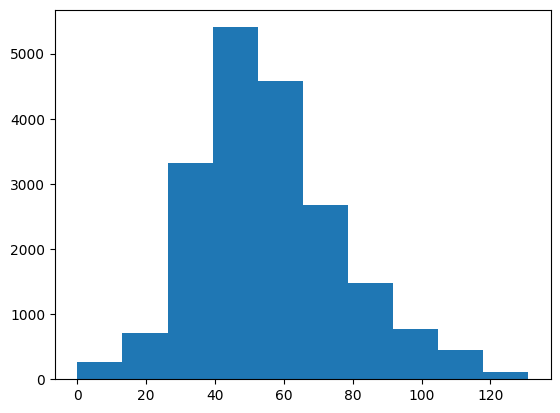

In [14]:
plt.hist(n_charged + n_neutral)

### Overwrite

- `hgpflow_pt` for neutral particles is better than `proxy_pt`
- But the rest are just worse
- So, I will just overwrite the `hgpflow_xxx` with `proxy_xxx` for the rest

In [15]:
# perf_obj.data["hgpflow"]["eta"] = perf_obj.data["hgpflow"]["proxy_eta"]
# perf_obj.data["hgpflow"]["phi"] = perf_obj.data["hgpflow"]["proxy_phi"]
# perf_obj.data["hgpflow"]["pt"] = perf_obj.data["hgpflow"]["proxy_pt"]

# for i in range(len(perf_obj.data["hgpflow"]["pt"])):
#     ch_mask = perf_obj.data["hgpflow"]["class"][i] <= 2
#     perf_obj.data["hgpflow"]["pt"][i][ch_mask] = perf_obj.data["hgpflow"]["proxy_pt"][i][ch_mask]

In [16]:
idx = 0

print("Particle data")
print(np.sort(perf_obj.truth_dict["particle_pt"][idx][perf_obj.truth_dict["particle_class"][idx] <= 2])[::-1])
print("MPflow proxy data")
print(np.sort(perf_obj.data["mpflow"]["proxy_pt"][idx][perf_obj.data["mpflow"]["class"][idx] <= 2])[::-1])
# print("HGPflow proxy data")
# print(np.sort(perf_obj.data['hgpflow']['proxy_pt'][idx][perf_obj.data['hgpflow']['class'][idx] <= 2])[::-1])

Particle data
[2.05544543 2.00689816 1.22862697 1.21958816 0.94735843 0.93824512
 0.68863207 0.58046174 0.57142735 0.56641656 0.51084858 0.45804888
 0.45783955 0.3199735  0.26255557 0.26148829 0.2348657  0.2299964
 0.22890501 0.17870697]
MPflow proxy data
[23.140516    9.781012    4.839227    4.0573926   3.6415377   3.1533294
  2.363066    2.0483649   2.0483649   1.9732016   1.4224751   1.3599572
  1.1239315   1.0143477   0.719316    0.719316    0.719316    0.43903565]


In [ ]:
with uproot.open("/share/gpu1/syw24/dmitrii_clic/test_clic_common_raw.root") as f:
    track_pt = f["events;1"]["track_pt"].array(library="np")

In [18]:
track_pt[0]

array([2.05576324, 2.00231314, 1.22795355, 0.94966769, 0.94607526,
       0.60721469, 0.57421523, 0.52669734, 0.45971552, 0.45850766,
       0.26150492, 0.14520171, 0.23455974, 0.22790611, 0.18378501,
       1.22328436, 0.32035479, 0.57939988, 0.5837239 ])

In [19]:
perf_obj.compute_jets(n_procs=20)
perf_obj.match_jets()

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7
truth
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   0%|                                                                                          | 1/988 [00:00<03:59,  4.11it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  #--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#------------

Computing jets...:   3%|██▊                                                                                     | 32/989 [00:00<00:05, 173.84it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|██▉                                                                                     | 33/989 [00:00<00:05, 177.21it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  13%|███████████▎                                                                           | 128/988 [00:00<00:03, 215.34it/s]

Jet clustering algorithm:  genkt


Computing jets...:  11%|█████████▌                                                                             | 109/989 [00:00<00:03, 237.55it/s]

Jet clustering radius:  0.7


Computing jets...:  18%|███████████████▉                                                                       | 181/988 [00:00<00:03, 237.90it/s]

Jet clustering algorithm: #--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#-------------------------------------------

Computing jets...:  24%|████████████████████▋                                                                  | 235/988 [00:01<00:03, 250.59it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  16%|█████████████▊                                                                         | 157/989 [00:00<00:03, 232.13it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  39%|██████████████████████████████████▏                                                    | 388/989 [00:01<00:02, 277.67it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  39%|██████████████████████████████████                                                     | 387/988 [00:01<00:02, 223.93it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  33%|████████████████████████████▌                                                          | 324/989 [00:01<00:02, 266.83it/s]

Computing jets...:  22%|██████████████████▋                                                                    | 213/989 [00:00<00:03, 252.04it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  27%|███████████████████████▋                                                               | 269/989 [00:01<00:02, 240.88it/s]

Jet clustering algorithm:  #--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#------------------------------------------

Computing jets...:   3%|██▊                                                                                     | 32/989 [00:00<00:06, 155.21it/s]


Jet clustering radius:  0.7


Computing jets...:  13%|███████████▎                                                                           | 128/989 [00:00<00:04, 209.23it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  41%|███████████████████████████████████▊                                                   | 407/989 [00:01<00:02, 262.83it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  60%|████████████████████████████████████████████████████▍                                  | 596/988 [00:02<00:01, 206.06it/s]

Jet clustering algorithm: 

Computing jets...:   7%|██████▌                                                                                 | 74/989 [00:00<00:04, 204.71it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  50%|███████████████████████████████████████████▍                                           | 494/989 [00:02<00:02, 240.18it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------

Computing jets...:  55%|███████████████████████████████████████████████▊                                       | 543/989 [00:02<00:02, 221.74it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  71%|█████████████████████████████████████████████████████████████▊                         | 702/989 [00:03<00:01, 172.40it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  71%|█████████████████████████████████████████████████████████████▋                         | 701/988 [00:03<00:02, 143.43it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...:  62%|██████████████████████████████████████████████████████                                 | 614/989 [00:02<00:01, 201.79it/s]

Jet clustering algorithm:  

Computing jets...:  73%|███████████████████████████████████████████████████████████████▏                       | 717/988 [00:03<00:01, 146.39it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  78%|████████████████████████████████████████████████████████████████████▏                  | 774/988 [00:04<00:01, 172.76it/s]

Jet clustering algorithm: 

Computing jets...:  39%|██████████████████████████████████▏                                                    | 389/989 [00:02<00:04, 145.02it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  83%|████████████████████████████████████████████████████████████████████████▍              | 824/989 [00:03<00:00, 169.59it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  32%|███████████████████████████▊                                                           | 316/989 [00:01<00:04, 150.92it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  32%|███████████████████████████▌                                                           | 313/989 [00:01<00:04, 158.13it/s]

0.7


Computing jets...:  45%|███████████████████████████████████████▎                                               | 447/989 [00:02<00:02, 210.36it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  16%|█████████████▉                                                                         | 159/989 [00:00<00:04, 184.47it/s]

Jet clustering algorithm: 

Computing jets...:  96%|███████████████████████████████████████████████████████████████████████████████████▏   | 945/988 [00:05<00:00, 125.95it/s]

 genkt
Jet clustering radius:  0.7

Computing jets...:  44%|██████████████████████████████████████                                                 | 432/989 [00:02<00:03, 167.33it/s]

Computing jets...:  35%|██████████████████████████████▌                                                        | 348/989 [00:01<00:03, 210.37it/s]

Jet clustering algorithm: 

Computing jets...:  82%|███████████████████████████████████████████████████████████████████████▎               | 810/989 [00:04<00:01, 173.99it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  14%|████████████▏                                                                          | 139/989 [00:00<00:04, 184.95it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:04<00:00, 207.10it/s]


pandora
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   0%|                                                                                                  | 0/989 [00:00<?, ?it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   7%|██████▏                                                                                 | 70/989 [00:00<00:02, 317.49it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   5%|████▌                                                                                   | 51/989 [00:00<00:03, 249.27it/s]

Jet clustering algorithm:  genkt

Computing jets...:  19%|████████████████▉                                                                      | 192/988 [00:00<00:02, 272.09it/s]


Jet clustering radius:  0.7


Computing jets...:   3%|██▊                                                                                     | 32/989 [00:00<00:05, 160.06it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   7%|██████▍                                                                                 | 73/989 [00:00<00:04, 190.08it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   5%|████                                                                                    | 46/989 [00:00<00:04, 213.97it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   1%|▋                                                                                         | 7/989 [00:00<00:14, 66.91it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|███████████████████▎                                                                   | 220/989 [00:01<00:03, 239.20it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  25%|█████████████████████▉                                                                 | 249/989 [00:01<00:02, 254.14it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  13%|███████████▍                                                                           | 130/989 [00:00<00:03, 228.44it/s]

Jet clustering algorithm:  genkt

Computing jets...:  31%|██████████████████████████▋                                                            | 304/989 [00:01<00:02, 257.27it/s]


Jet clustering radius:  0.7


Computing jets...:  60%|████████████████████████████████████████████████████▌                                  | 597/988 [00:02<00:01, 216.91it/s]

Jet clustering algorithm:  genkt


Computing jets...:   6%|█████▏                                                                                  | 58/989 [00:00<00:06, 142.96it/s]

Jet clustering radius:  0.7


Computing jets...:  62%|█████████████████████████████████████████████████████▋                                 | 611/989 [00:02<00:01, 193.35it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|███████████████████                                                                    | 216/989 [00:01<00:04, 154.81it/s]

Jet clustering algorithm:  

Computing jets...:  80%|█████████████████████████████████████████████████████████████████████▊                 | 793/988 [00:03<00:01, 189.06it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  84%|█████████████████████████████████████████████████████████████████████████▎             | 832/988 [00:03<00:00, 173.59it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  60%|███████████████████████████████████████████████████▉                                   | 591/989 [00:02<00:01, 200.44it/s]

Computing jets...:  31%|██████████████████████████▊                                                            | 305/989 [00:01<00:03, 190.40it/s]

Jet clustering algorithm: 

Computing jets...:  59%|███████████████████████████████████████████████████                                    | 581/989 [00:02<00:02, 186.36it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  14%|████████████▍                                                                          | 141/989 [00:00<00:05, 155.46it/s]

Jet clustering algorithm: 

Computing jets...:  65%|████████████████████████████████████████████████████████▉                              | 647/989 [00:03<00:01, 191.16it/s]

 genkt
Jet clustering radius:  

Computing jets...:  94%|█████████████████████████████████████████████████████████████████████████████████▍     | 925/988 [00:04<00:00, 153.26it/s]

0.7


Computing jets...:  97%|████████████████████████████████████████████████████████████████████████████████████▏  | 956/988 [00:04<00:00, 143.25it/s]

Jet clustering algorithm: 

Computing jets...:  62%|█████████████████████████████████████████████████████▌                                 | 609/989 [00:03<00:02, 180.56it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  88%|████████████████████████████████████████████████████████████████████████████▉          | 875/989 [00:04<00:00, 169.39it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  18%|███████████████▊                                                                       | 180/989 [00:00<00:03, 202.41it/s]

0.7


Computing jets...:  95%|██████████████████████████████████████████████████████████████████████████████████▋    | 940/989 [00:04<00:00, 235.77it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:05<00:00, 194.36it/s]


mpflow jets
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|█▎                                                                                      | 15/988 [00:00<00:06, 148.51it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  10%|████████▊                                                                               | 99/989 [00:00<00:04, 204.31it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  17%|███████████████                                                                        | 171/988 [00:00<00:03, 208.59it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|██████████████████▊                                                                    | 213/988 [00:01<00:03, 201.58it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  10%|████████▍                                                                               | 95/989 [00:00<00:04, 186.64it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|██▍                                                                                     | 27/989 [00:00<00:06, 138.13it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  31%|██████████████████████████▉                                                            | 306/989 [00:01<00:03, 196.60it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  38%|█████████████████████████████████▎                                                     | 379/988 [00:01<00:03, 191.56it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  35%|██████████████████████████████▍                                                        | 346/989 [00:01<00:03, 190.83it/s]

 0.7

Computing jets...:   2%|█▋                                                                                       | 19/989 [00:00<00:10, 92.26it/s]

Computing jets...:  29%|████████████████████████▉                                                              | 283/989 [00:01<00:03, 192.55it/s]

Jet clustering algorithm:  

Computing jets...:  12%|██████████                                                                             | 115/989 [00:00<00:05, 169.75it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  18%|███████████████▊                                                                       | 180/989 [00:01<00:05, 150.86it/s]

Jet clustering algorithm: 

Computing jets...:   5%|████▊                                                                                   | 54/989 [00:00<00:06, 138.51it/s]

 genkt

Computing jets...:  10%|████████▍                                                                               | 95/989 [00:00<00:05, 170.60it/s]


Jet clustering radius:  0.7


Computing jets...:  51%|████████████████████████████████████████████▍                                          | 505/988 [00:02<00:02, 172.45it/s]

Jet clustering algorithm:  

Computing jets...:  27%|███████████████████████▍                                                               | 266/989 [00:01<00:04, 146.88it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  11%|█████████▊                                                                             | 112/989 [00:00<00:06, 143.21it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  31%|██████████████████████████▋                                                            | 303/989 [00:02<00:05, 118.28it/s]

 0.7


Computing jets...:  27%|███████████████████████▎                                                               | 265/989 [00:01<00:05, 134.66it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:   3%|██▊                                                                                     | 32/989 [00:00<00:06, 154.58it/s]

0.7

Computing jets...:  34%|█████████████████████████████▌                                                         | 336/989 [00:02<00:04, 133.29it/s]

Computing jets...:  22%|██████████████████▋                                                                    | 213/989 [00:01<00:04, 165.34it/s]

Jet clustering algorithm:  

Computing jets...:  37%|████████████████████████████████                                                       | 364/989 [00:02<00:04, 125.51it/s]

genkt


Computing jets...:  10%|████████▍                                                                               | 95/989 [00:00<00:07, 122.12it/s]

Jet clustering radius:  0.7


Computing jets...:  50%|███████████████████████████████████████████▋                                           | 496/989 [00:03<00:03, 135.40it/s]

Jet clustering algorithm:  

Computing jets...:  14%|███████████▉                                                                           | 135/989 [00:00<00:04, 189.51it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  31%|███████████████████████████                                                            | 308/989 [00:02<00:04, 163.13it/s]

Jet clustering algorithm:  

Computing jets...:  56%|████████████████████████████████████████████████▉                                      | 557/989 [00:03<00:02, 178.03it/s]

genkt


Computing jets...:  17%|██████████████▊                                                                        | 169/989 [00:01<00:06, 121.57it/s]

Jet clustering radius: 

Computing jets...:  25%|██████████████████████▏                                                                | 252/989 [00:01<00:05, 140.05it/s]

 0.7

Computing jets...:  32%|███████████████████████████▍                                                           | 312/989 [00:02<00:05, 127.58it/s]

Computing jets...:   7%|█████▉                                                                                  | 67/989 [00:00<00:07, 125.73it/s]

Jet clustering algorithm: 

Computing jets...:  34%|█████████████████████████████▊                                                         | 339/989 [00:02<00:05, 113.25it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  52%|████████████████████████████████████████████▉                                          | 511/989 [00:03<00:03, 128.72it/s]

Jet clustering algorithm:  genkt

Computing jets...:   2%|█▊                                                                                       | 20/989 [00:00<00:10, 88.90it/s]


Jet clustering radius:  

Computing jets...:   9%|████████▏                                                                               | 92/989 [00:00<00:07, 115.28it/s]

0.7


Computing jets...:   2%|█▉                                                                                      | 22/989 [00:00<00:09, 101.47it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  39%|█████████████████████████████████▉                                                     | 386/989 [00:03<00:05, 106.29it/s]

0.7


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:06<00:00, 143.70it/s]


Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|█▍                                                                                      | 16/988 [00:00<00:06, 155.89it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   9%|███████▍                                                                                | 84/988 [00:00<00:04, 214.36it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|███▏                                                                                    | 36/989 [00:00<00:05, 171.77it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  11%|█████████▌                                                                             | 108/989 [00:00<00:05, 169.24it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  18%|███████████████▍                                                                       | 176/988 [00:00<00:03, 212.16it/s]

0.7


Computing jets...:   6%|████▉                                                                                   | 56/989 [00:00<00:05, 181.30it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  10%|████████▍                                                                               | 95/989 [00:00<00:04, 186.75it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|█▉                                                                                      | 22/989 [00:00<00:09, 100.14it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  18%|███████████████▍                                                                       | 176/989 [00:00<00:04, 190.08it/s]

Jet clustering algorithm:  

Computing jets...:  11%|█████████▌                                                                             | 109/989 [00:00<00:04, 188.65it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  22%|███████████████████                                                                    | 216/989 [00:01<00:03, 194.35it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  41%|███████████████████████████████████▉                                                   | 408/988 [00:02<00:02, 197.80it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   9%|███████▌                                                                                | 85/989 [00:00<00:07, 115.89it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  43%|█████████████████████████████████████▏                                                 | 423/989 [00:02<00:03, 175.71it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  16%|█████████████▋                                                                         | 155/989 [00:00<00:05, 147.20it/s]

Jet clustering algorithm: 

Computing jets...:   2%|██                                                                                      | 23/989 [00:00<00:08, 114.00it/s]

 genkt

Computing jets...:  31%|██████████████████████████▋                                                            | 304/989 [00:01<00:04, 141.02it/s]


Jet clustering radius:  0.7

Computing jets...:  10%|████████▉                                                                              | 102/989 [00:00<00:06, 137.83it/s]

Computing jets...:  34%|█████████████████████████████▋                                                         | 337/989 [00:02<00:04, 162.69it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  24%|█████████████████████▎                                                                 | 242/989 [00:01<00:04, 178.42it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  28%|████████████████████████▍                                                              | 278/989 [00:01<00:04, 174.09it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  41%|███████████████████████████████████▌                                                   | 404/989 [00:02<00:03, 158.99it/s]

Jet clustering algorithm: 

Computing jets...:  17%|██████████████▍                                                                        | 164/989 [00:01<00:07, 108.10it/s]

 genkt

Computing jets...:  26%|██████████████████████▌                                                                | 256/989 [00:01<00:05, 132.13it/s]


Jet clustering radius:  0.7


Computing jets...:  19%|████████████████▊                                                                      | 191/989 [00:01<00:06, 117.91it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  66%|█████████████████████████████████████████████████████████▋                             | 656/989 [00:04<00:02, 130.84it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Matching jets...: 100%|██████████████████████████████████████████████████████████████████████████████████| 19779/19779 [00:00<00:00, 26218.99it/s]


Process ForkPoolWorker-1:
Process ForkPoolWorker-15:
Process ForkPoolWorker-4:
Process ForkPoolWorker-20:
Process ForkPoolWorker-18:
Process ForkPoolWorker-16:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-19:
Process ForkPoolWorker-12:
Process ForkPoolWorker-17:
Process ForkPoolWorker-13:
Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-14:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/share/gpu1/syw24/hepattn/.pixi/envs/default/lib/python3.12/site-packages/mu

### Jet residual plots

In [20]:
_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_jets"],
    # 'mlpf': perf_obj.mlpf_dict['matched_mlpf_jets'],
    "mpflow": perf_obj.data["mpflow"]["matched_jets"],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_jets"],
    # "hgpflow": perf_obj.data["hgpflow"]["matched_proxy_jets"],
    # 'hgpflow_target': perf_obj.data['hgpflow_target']['matched_jets'],
}

jet_residual_dict = compute_jet_residual_dict(_dict, dr_cut=0.1, leading_N_jets=2, pt_min=10)

/tmp/ipykernel_100405/2474152153.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figs.tight_layout()


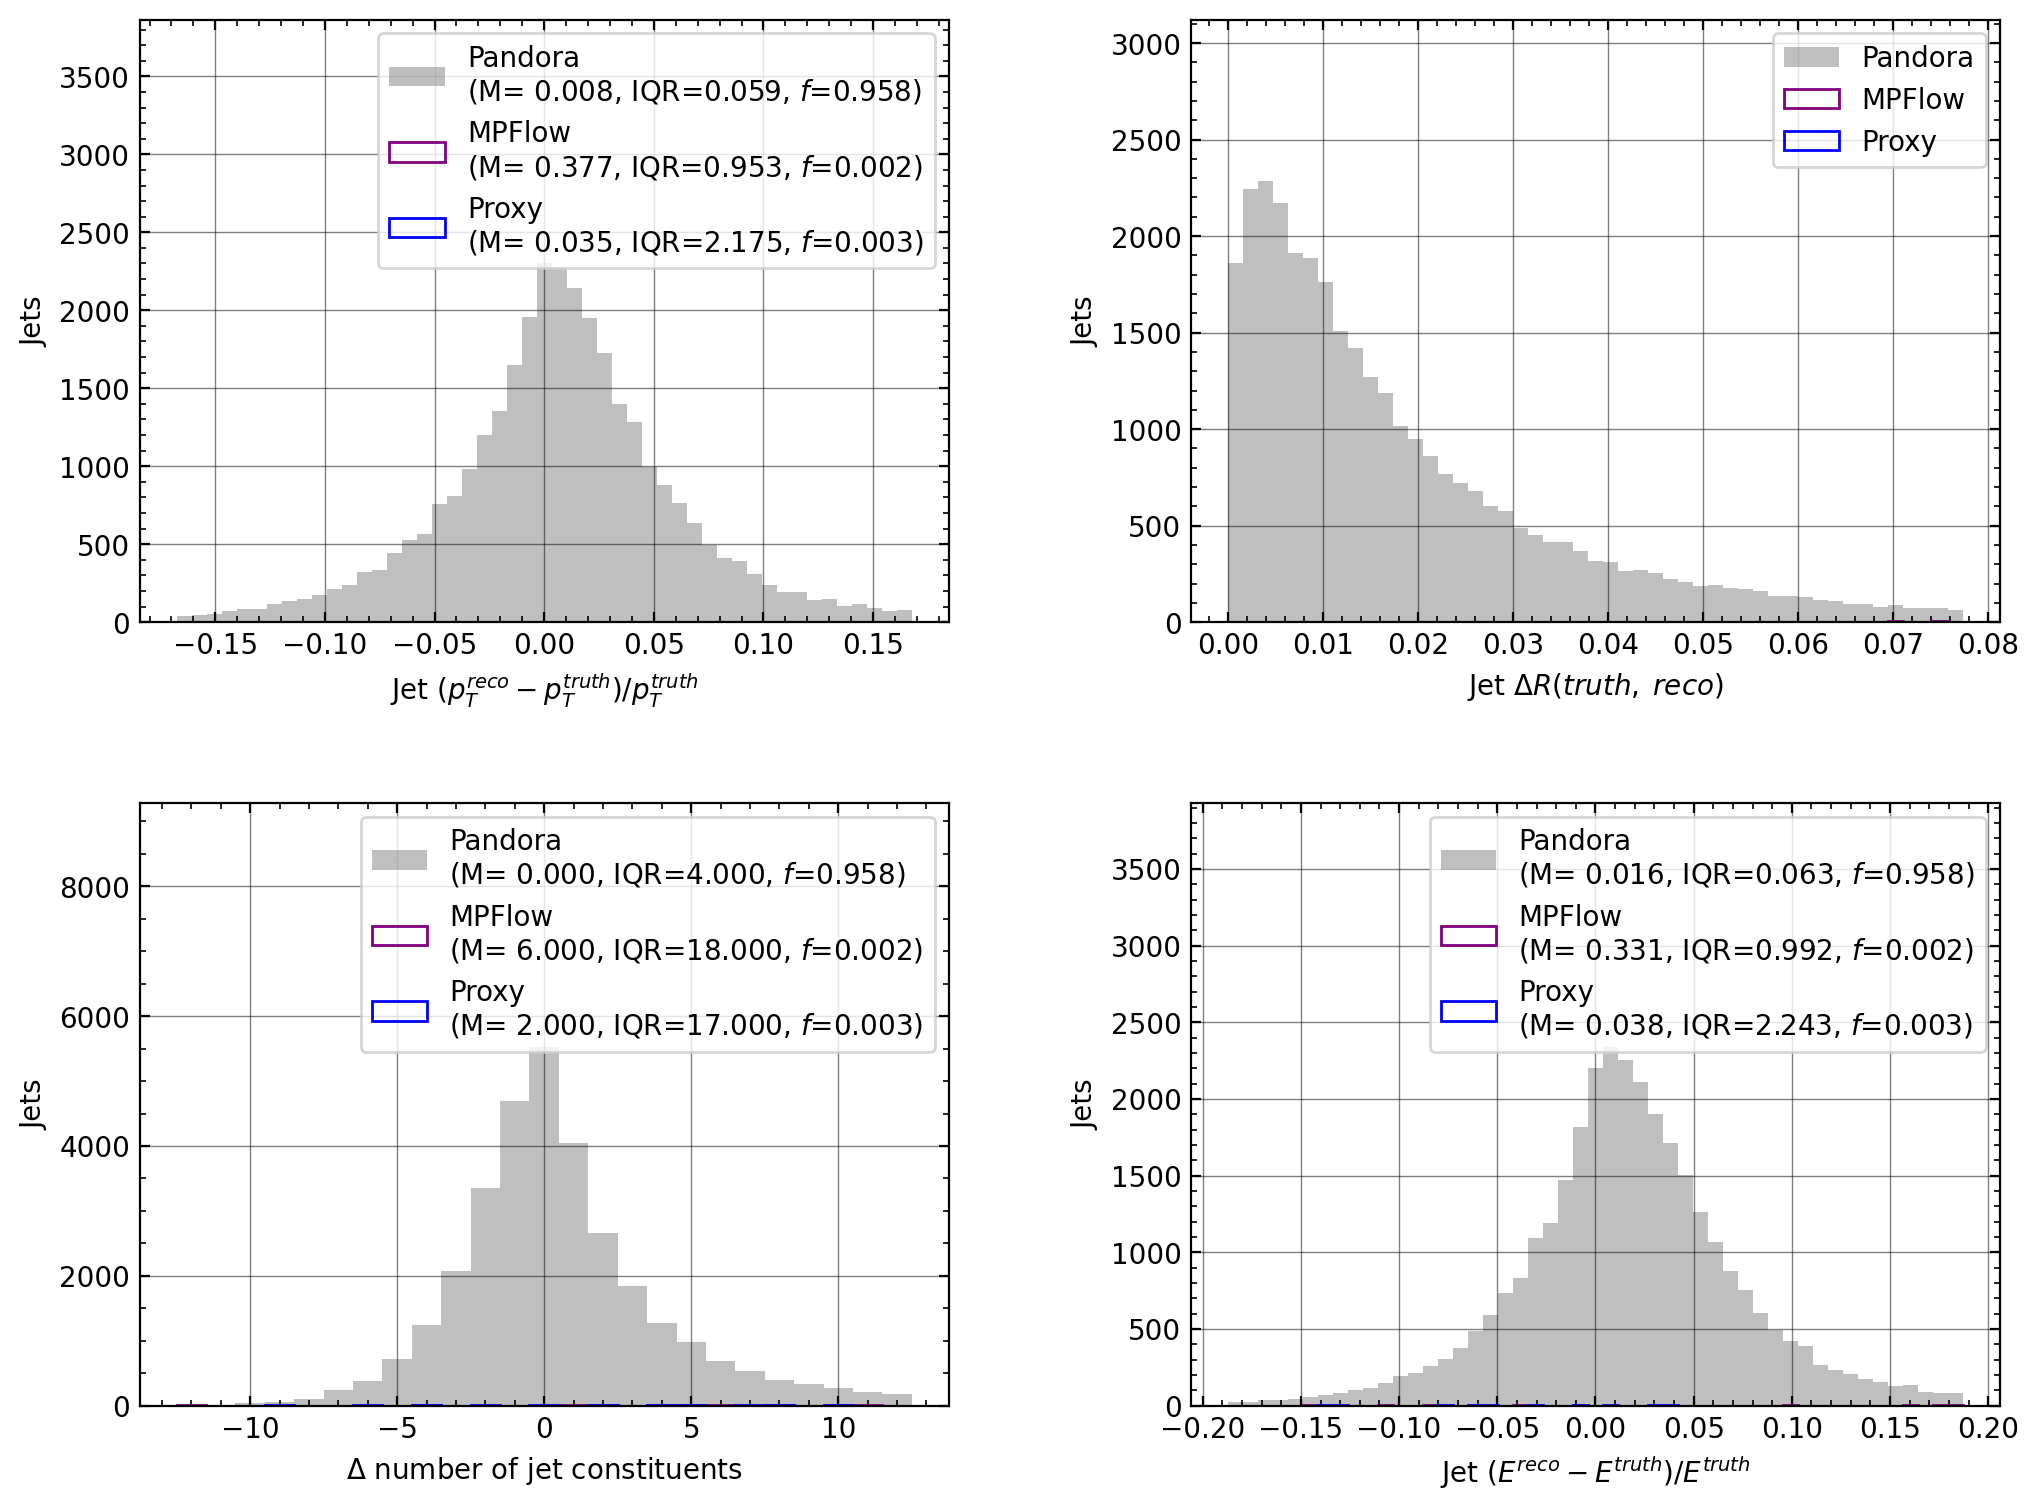

In [21]:
# change the x_lims

figs = plot_jet_residuals(jet_residual_dict, pt_relative=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/clic_dijet_jet_residuals_pt.png", dpi=300)
        figs[1].savefig(f"{save_dir}/clic_dijet_jet_residuals_dr.png", dpi=300)
        figs[2].savefig(f"{save_dir}/clic_dijet_jet_residuals_constcount.png", dpi=300)
        figs[3].savefig(f"{save_dir}/clic_dijet_jet_residuals_e.png", dpi=300)
    else:
        figs.tight_layout()
        figs.savefig(f"{save_dir}/clic_dijet_jet_residuals.png", dpi=300, bbox_inches="tight")

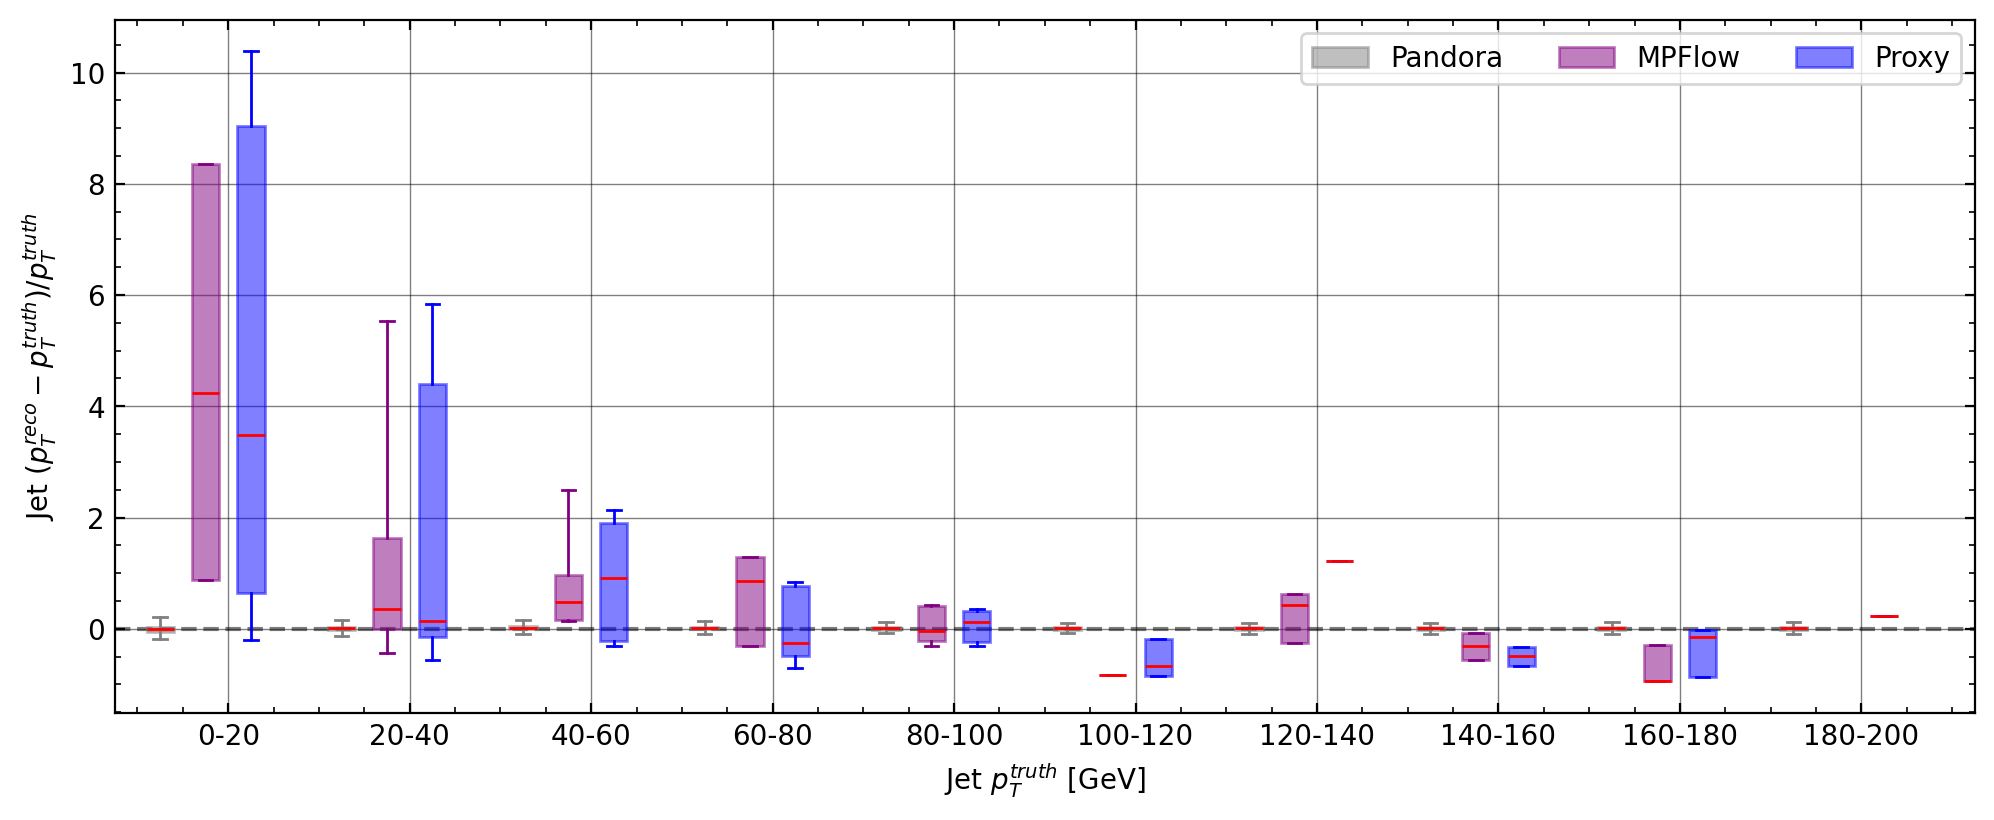

In [22]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_res_boxplot(jet_residual_dict, bins=pt_bins, var="pt")
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_residuals_boxplot_pt.png", dpi=300)

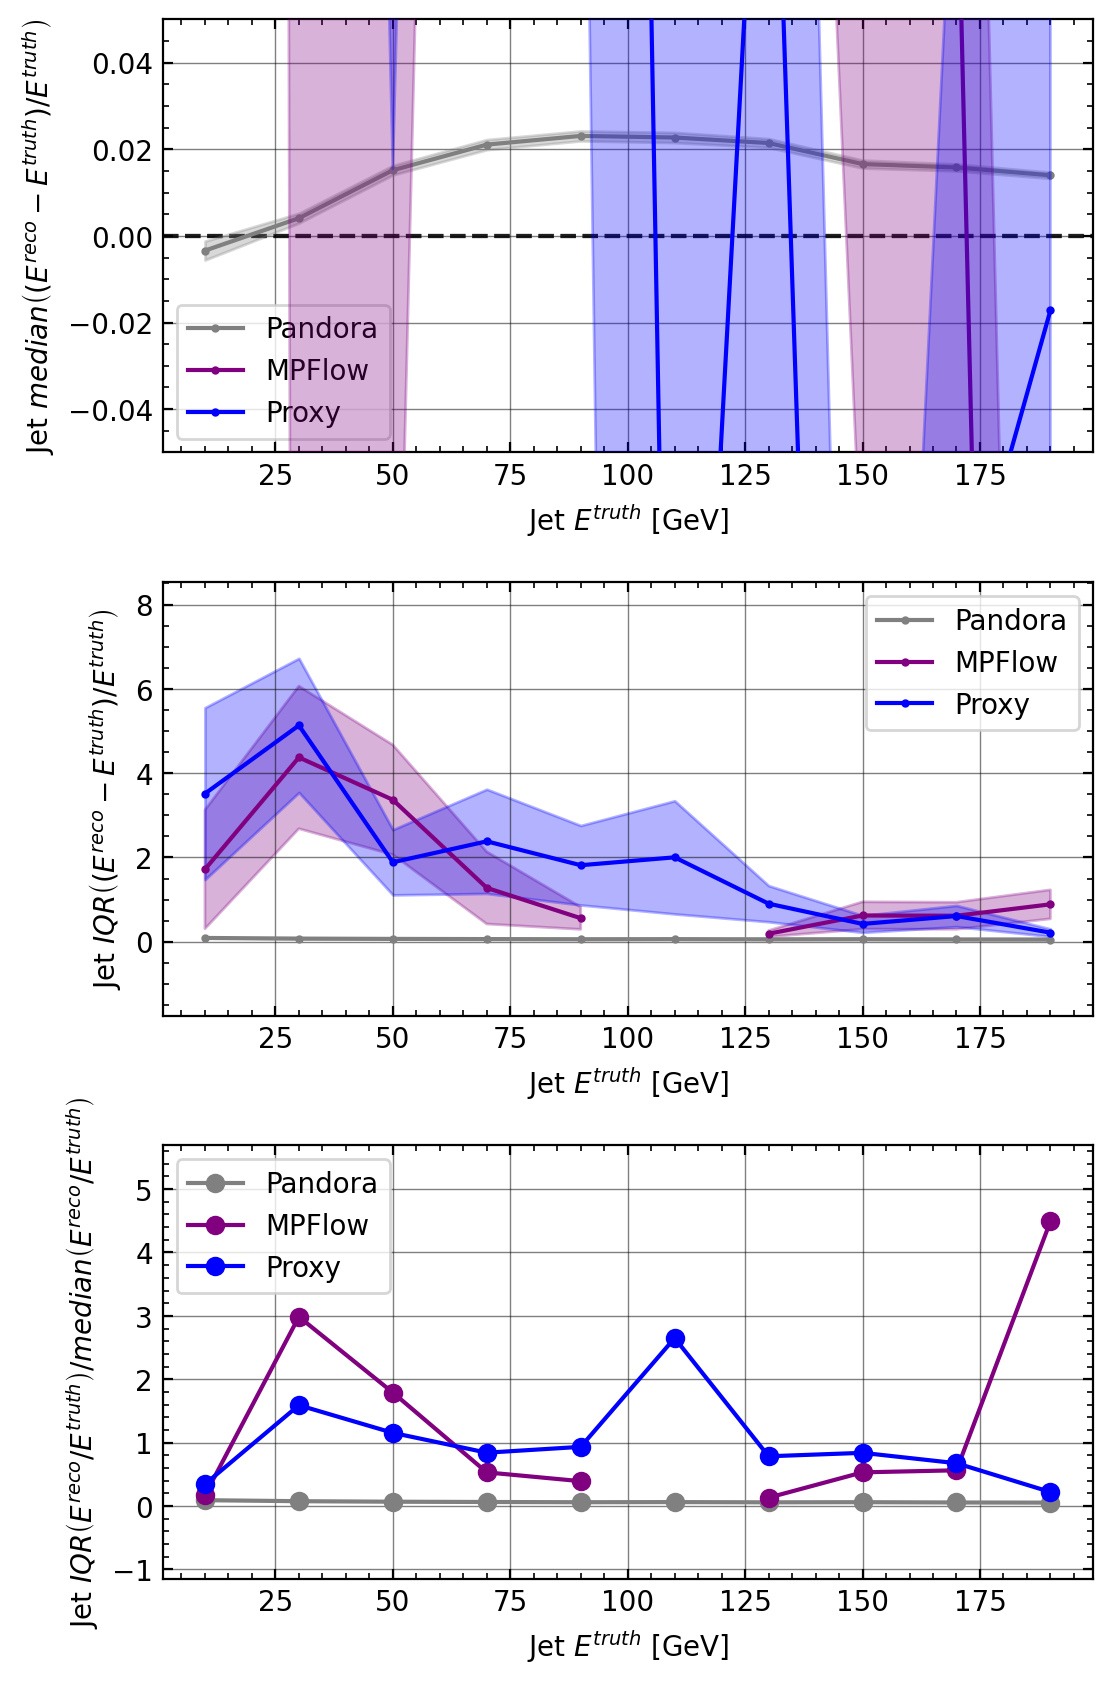

In [23]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_response(jet_residual_dict, pt_bins=pt_bins, use_energy=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(fig, list):
        for i, f in enumerate(fig):
            f.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot_{i}.png", dpi=300)
    else:
        fig.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot.png", dpi=300, bbox_inches="tight")

### jet marginal distributions

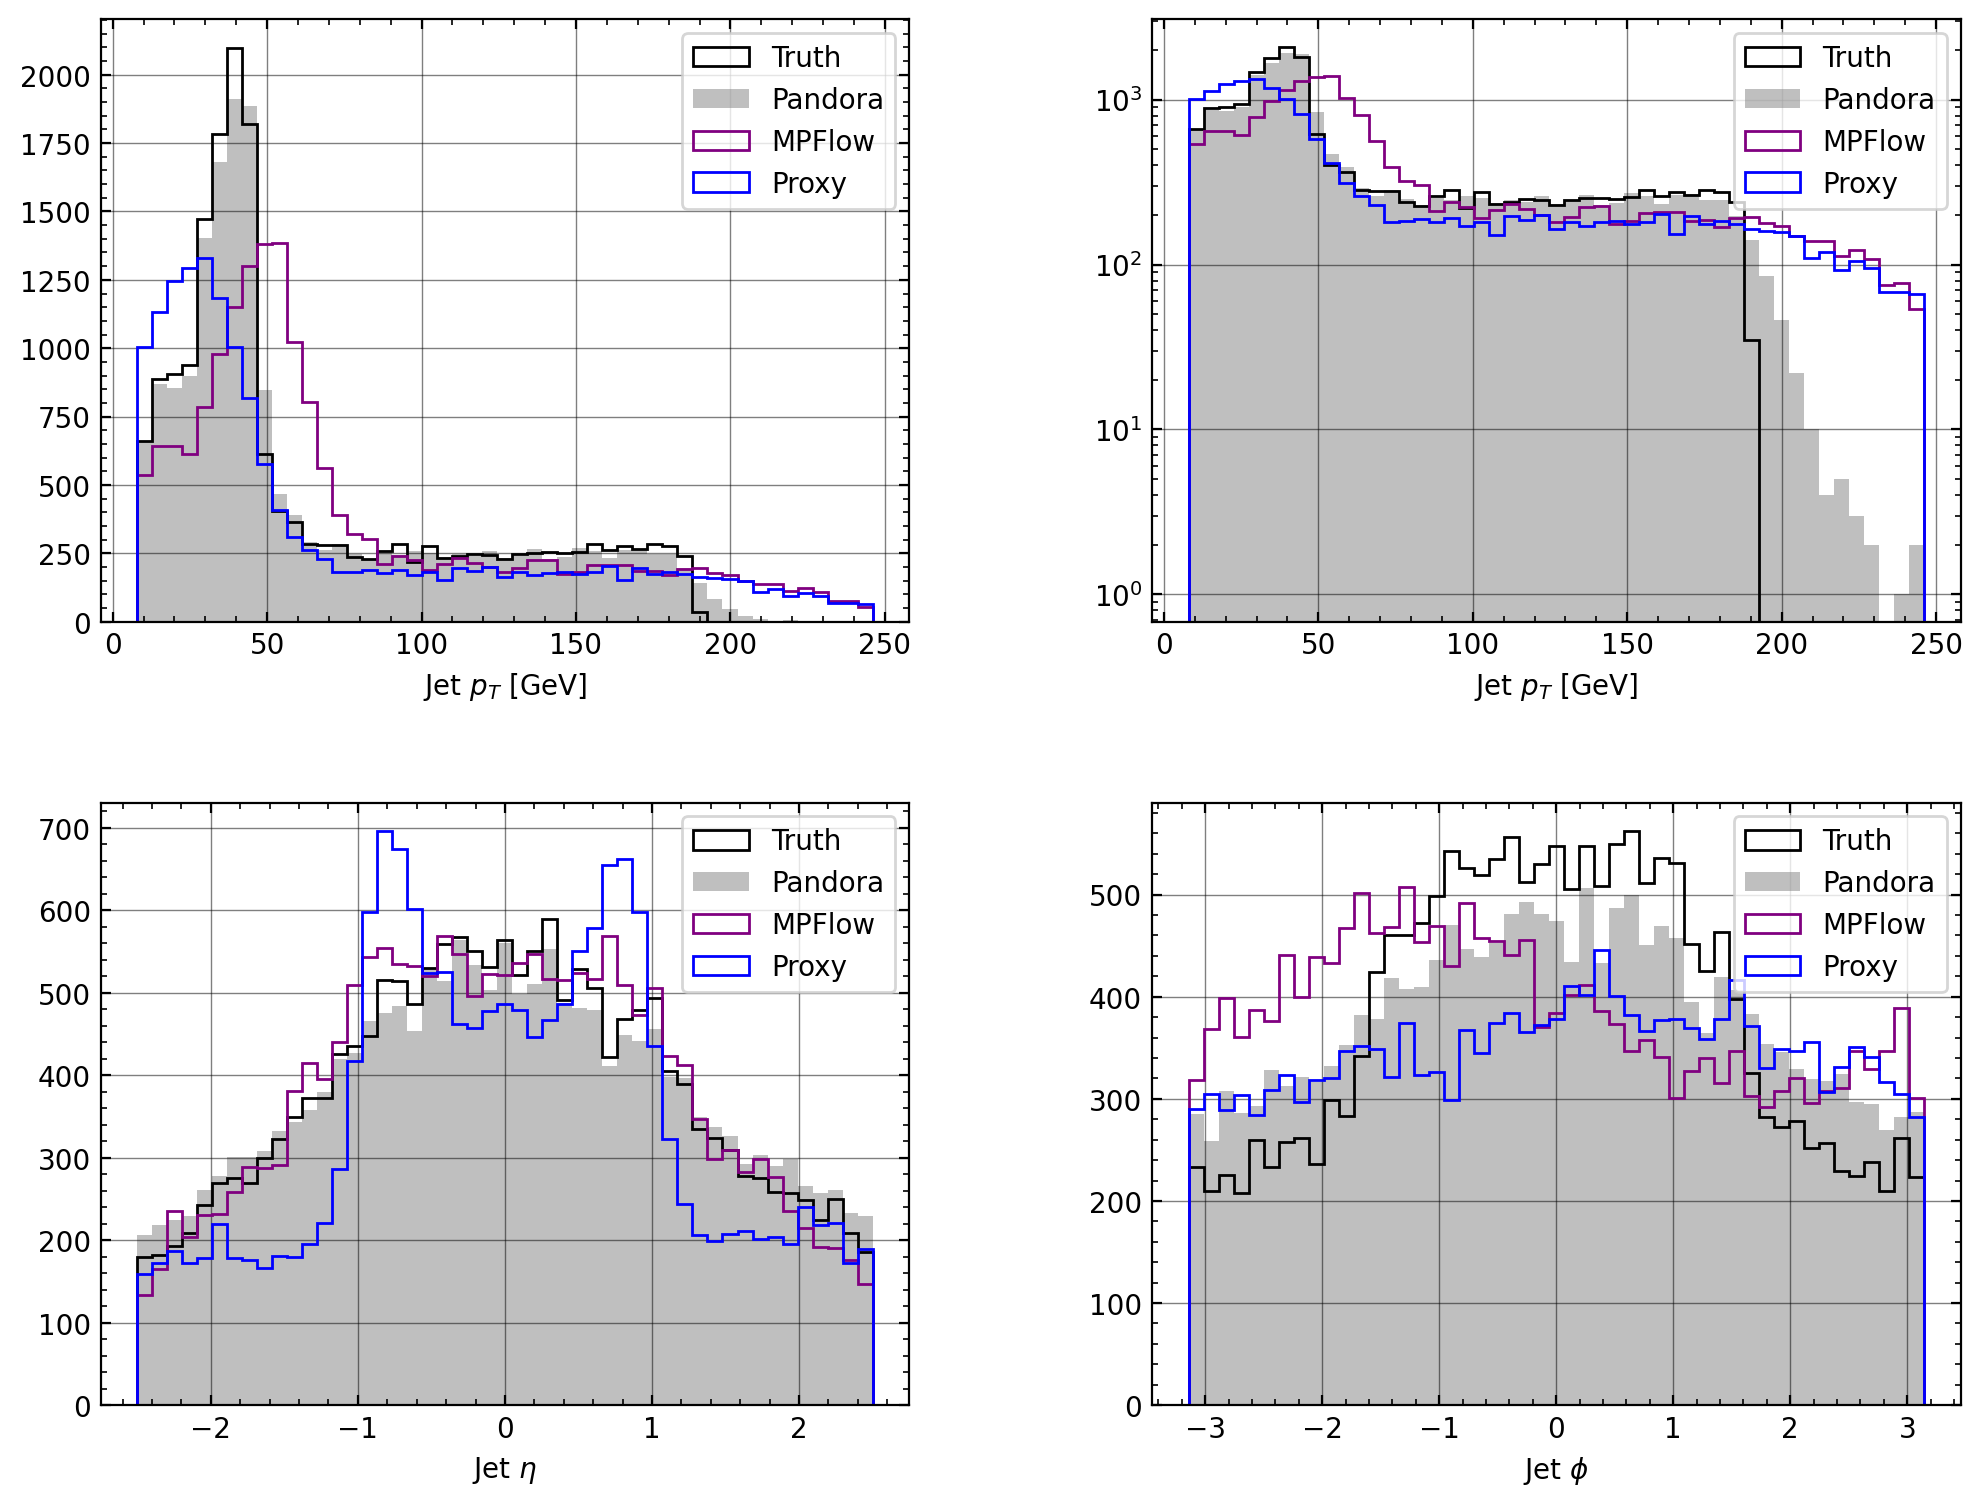

In [24]:
jet_dict = {
    "truth": perf_obj.truth_dict["truth_jets"],
    "pandora": perf_obj.truth_dict["pandora_jets"],
    # 'mlpf': perf_obj.mlpf_dict['jets'],
    "mpflow": perf_obj.data["mpflow"]["jets"],
    "proxy": perf_obj.data["mpflow"]["proxy_jets"],
    # "hgpflow": perf_obj.data["hgpflow"]["jets"],
}

fig = plot_jet_marginals(jet_dict, nleading=1, stylesheet=None)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_marginals.png", dpi=300, bbox_inches="tight")

## Particle performance

In [25]:
perf_obj.hung_match_particles(flatten=True, return_unmatched=True)

Matching particles...:   0%|                                                                                            | 0/19779 [00:00<?, ?it/s]

Matching particles...: 100%|██████████████████████████████████████████████████████████████████████████████| 19779/19779 [00:05<00:00, 3648.97it/s]


In [26]:
style_sheet_eff_fr = {
    "LINE_STYLES": {
        "proxy": "-",
        "mpflow": "-.",
        "pandora": "--",
    },
    "COLORS": {
        "proxy": {
            "neut had": "mediumseagreen",
            "photon": "tomato",
        },
        "mpflow": {
            "neut had": "orange",
            "photon": "darkorchid",
        },
        "pandora": {
            "neut had": "dodgerblue",
            "photon": "goldenrod",
        },
    },
}

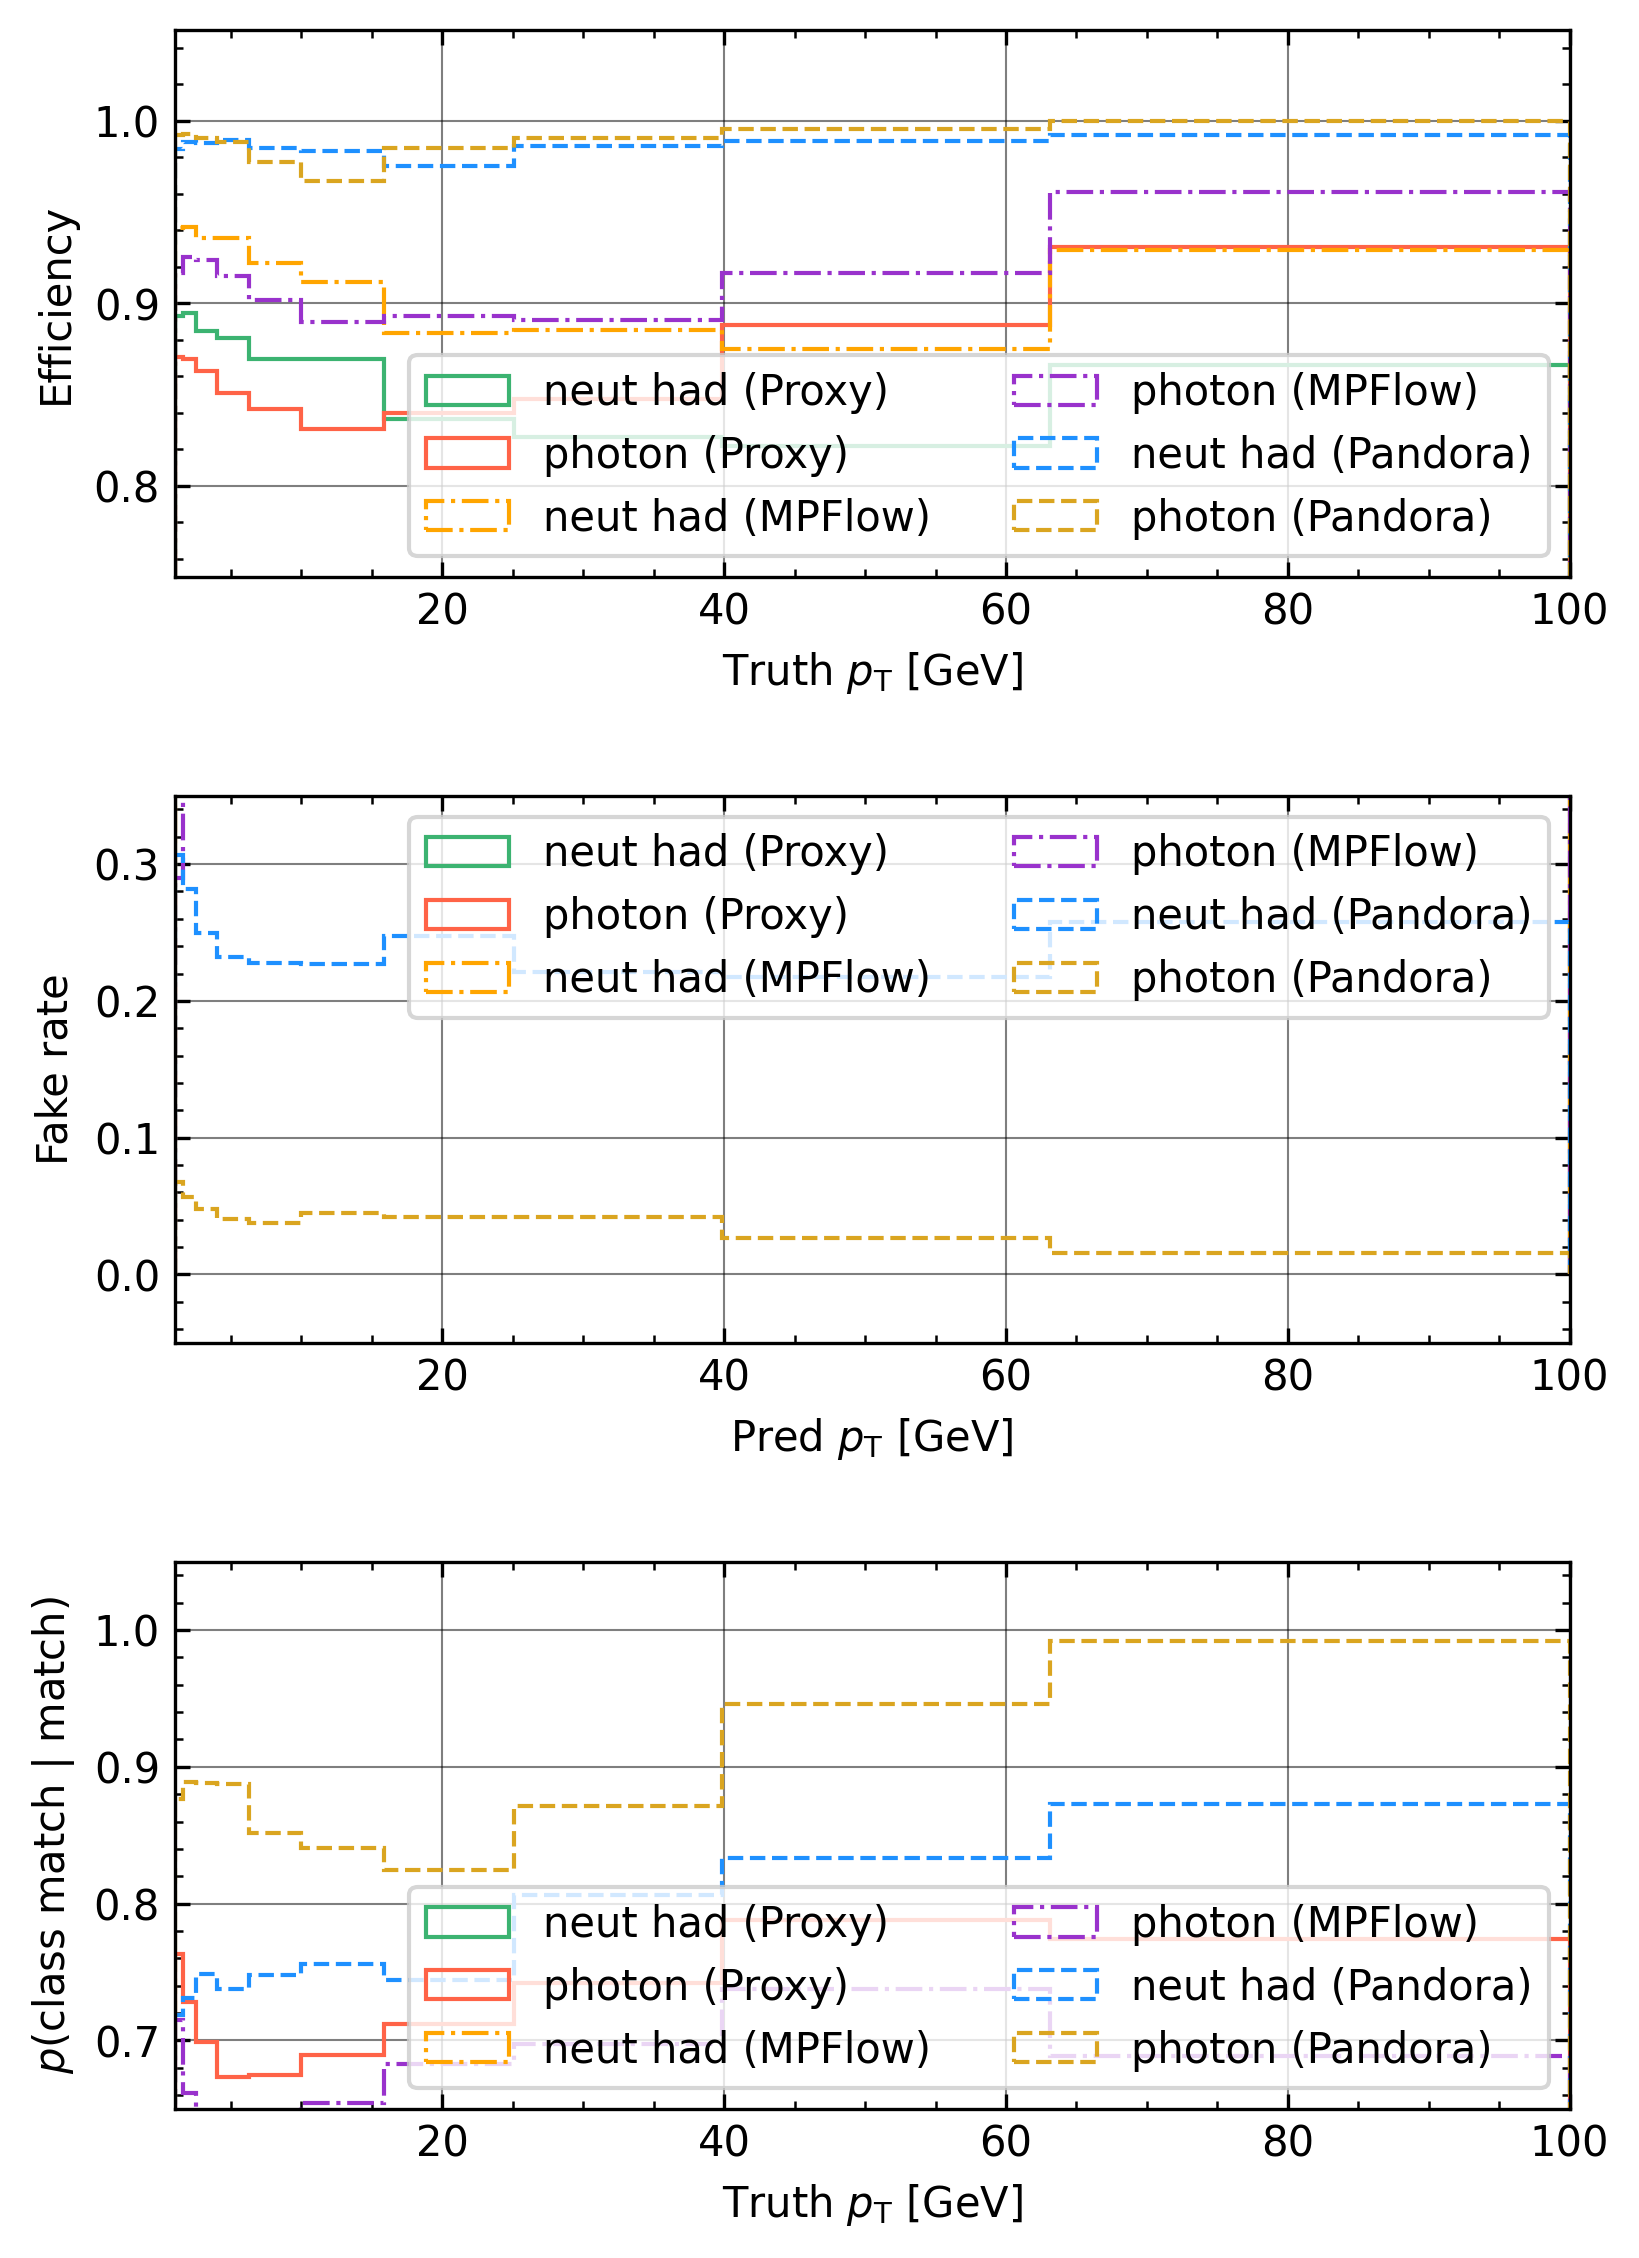

In [27]:
eff_fr_purity_input_dict = {
    "proxy": {
        "ref_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][0],
        "comp_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][1],
        "ref_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][2],
        "comp_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][3],
    },
    "mpflow": {
        "ref_matched": perf_obj.data["mpflow"]["matched_particles"][0],
        "comp_matched": perf_obj.data["mpflow"]["matched_particles"][1],
        "ref_unmatched": perf_obj.data["mpflow"]["matched_particles"][2],
        "comp_unmatched": perf_obj.data["mpflow"]["matched_particles"][3],
    },
    "pandora": {
        "ref_matched": perf_obj.truth_dict["matched_pandora_particles"][0],
        "comp_matched": perf_obj.truth_dict["matched_pandora_particles"][1],
        "ref_unmatched": perf_obj.truth_dict["matched_pandora_particles"][2],
        "comp_unmatched": perf_obj.truth_dict["matched_pandora_particles"][3],
    },
}

fig = plot_eff_fr_purity(eff_fr_purity_input_dict, stylesheet=style_sheet_eff_fr)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_eff_fr_purity.png", dpi=300, bbox_inches="tight")

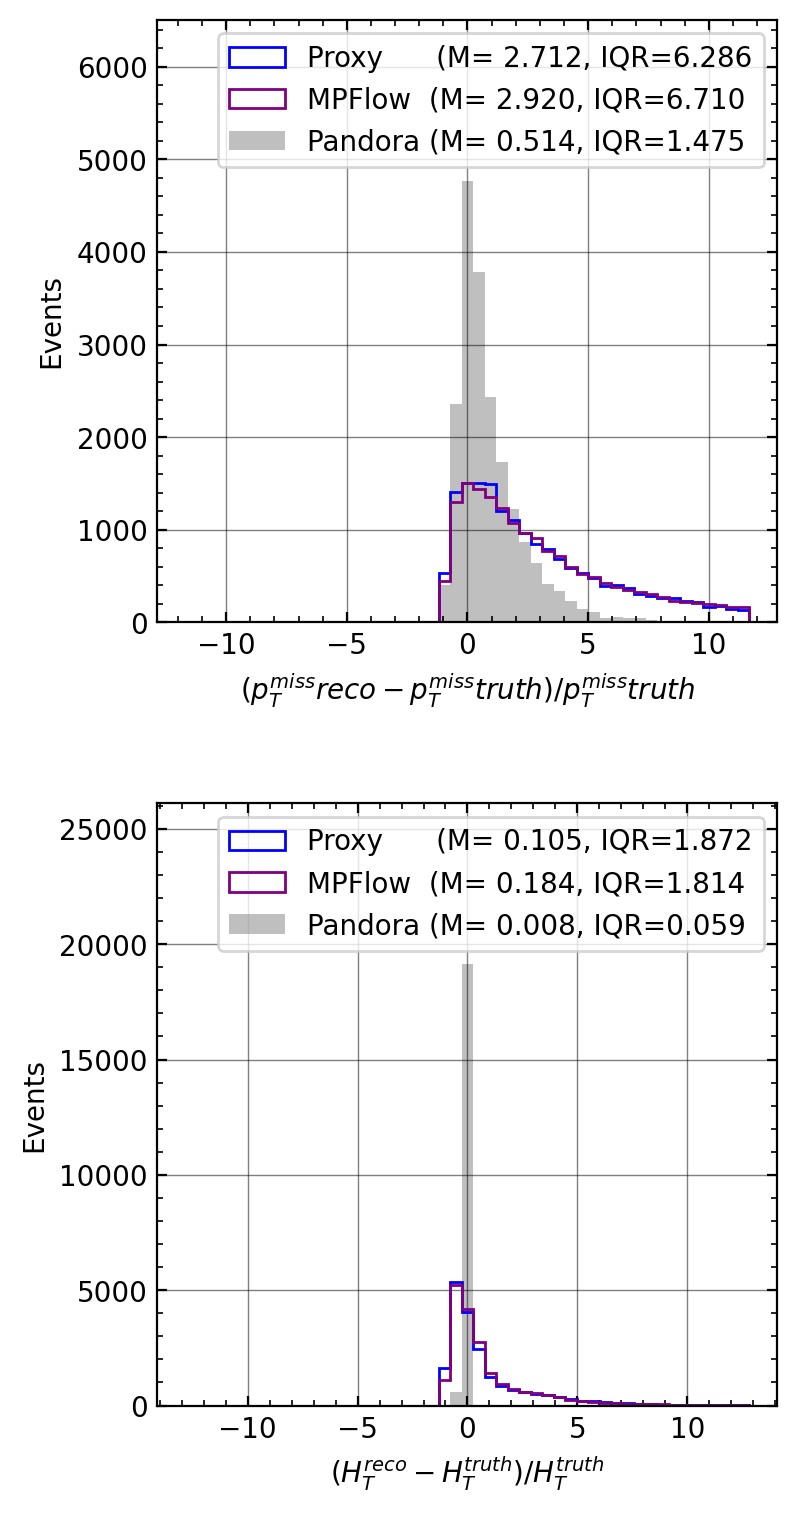

In [28]:
met_res_and_ht_res_input_dict = {
    "proxy": [perf_obj.data["mpflow"]["proxy_pt"], perf_obj.data["mpflow"]["proxy_phi"]],
    "mpflow": [perf_obj.data["mpflow"]["pt"], perf_obj.data["mpflow"]["phi"]],
    "pandora": [perf_obj.truth_dict["pandora_pt"], perf_obj.truth_dict["pandora_phi"]],
}
figs = plot_met_res_and_ht_res(
    perf_obj.truth_dict["particle_pt"], perf_obj.truth_dict["particle_phi"], met_res_and_ht_res_input_dict, stylesheet=None, separate_figures=False
)
if SAVE_FIG:
    if isinstance(figs, list):
        for i, f in enumerate(figs):
            f.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res_{i}.png", dpi=300)
    else:
        figs.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res.png", dpi=300, bbox_inches="tight")

/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:135: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))
/tmp/ipykernel_100405/907927751.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


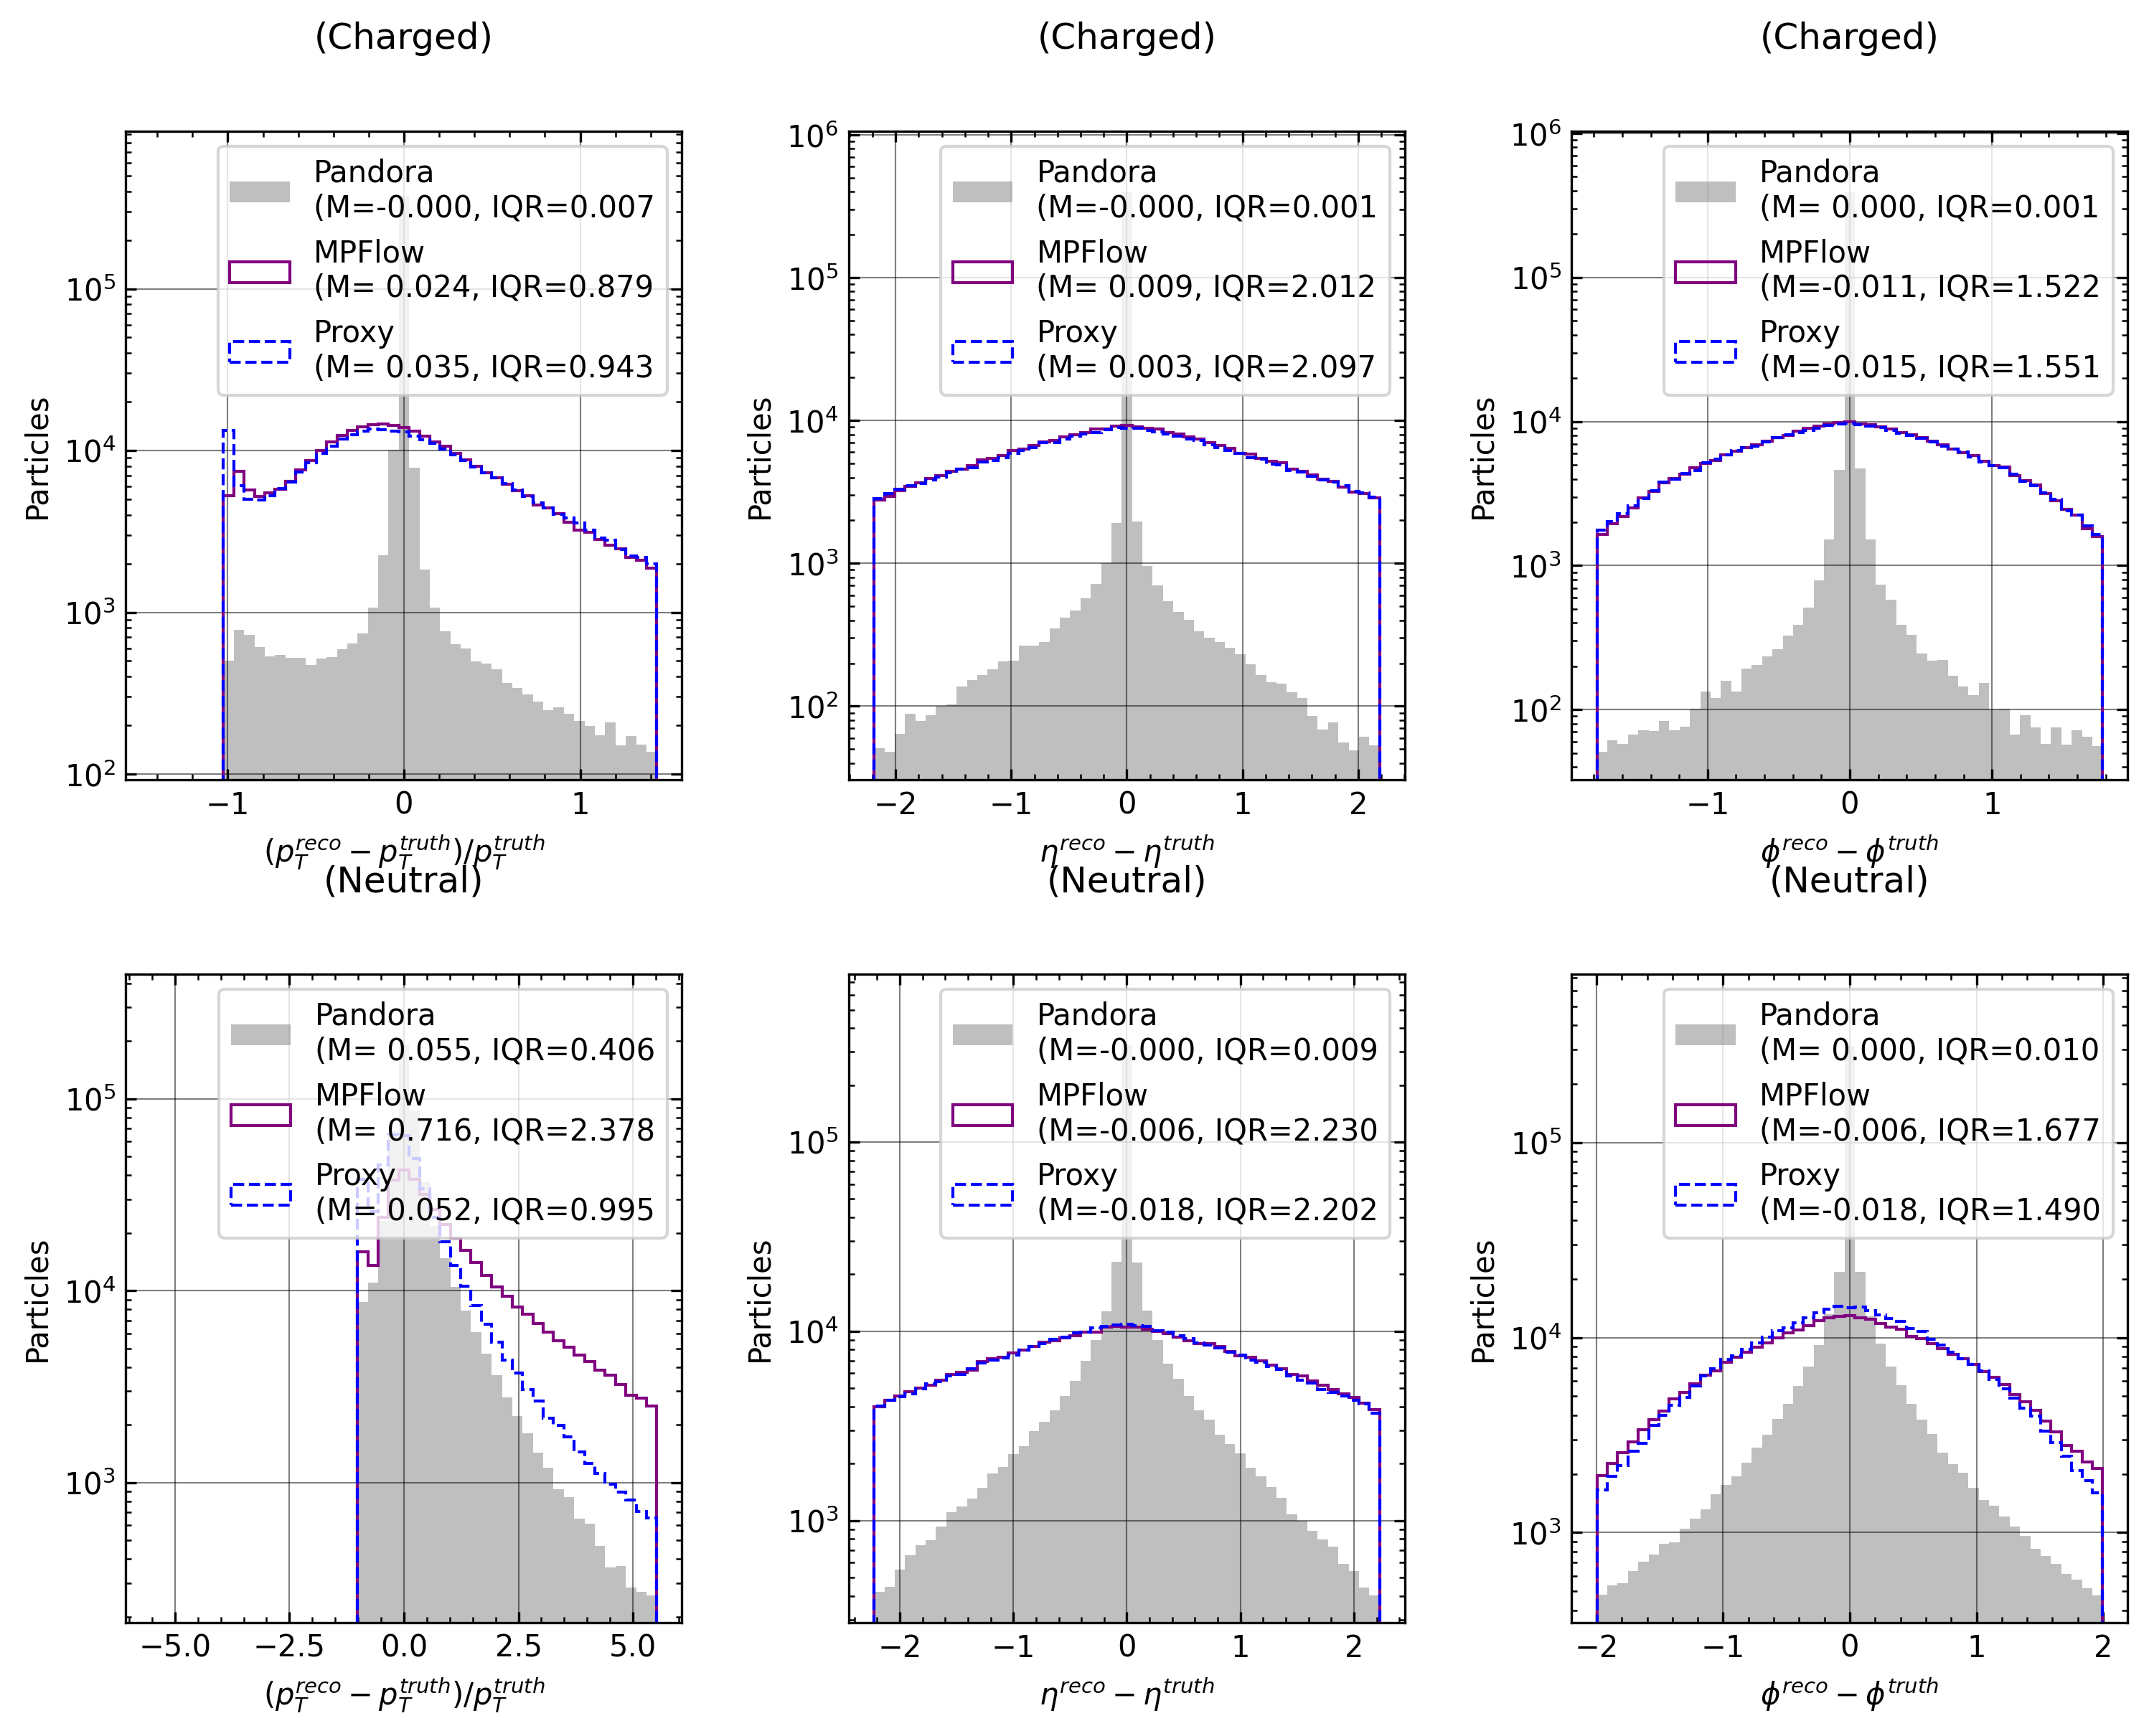

In [29]:
# from pflow.performance.plot_helper_particle import plot_residuals
from hepattn.experiments.clic.performance.style_sheet import LINE_STYLES

style_sheet_part_res = {
    "LINE_STYLES": deepcopy(LINE_STYLES),
}
style_sheet_part_res["LINE_STYLES"]["proxy"] = "--"
# style_sheet_part_res['COLORS']['proxy'] = 'dodgerblue'
# style_sheet_part_res['LINE_STYLES']['proxy'] = '-'

_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "mpflow": perf_obj.data["mpflow"]["matched_particles"],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
}

qs = {"Charged": {"pt": 90, "eta": 80, "phi": 80}, "Neutral": {"pt": 90, "eta": 80, "phi": 80}}
fig = plot_residuals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=style_sheet_part_res)
fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_particle_residuals.png", dpi=300, bbox_inches="tight")

In [30]:
_dict = {
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "mpflow": perf_obj.data["mpflow"]["matched_particles"],
}

qs = {"Neutral hadron": {"pt": 98, "eta": 75, "phi": 75}, "Photon": {"pt": 99, "eta": 90, "phi": 90}}
figs = plot_residuals_neutrals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=None, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_pt.png", dpi=300, bbox_inches="tight")
        figs[1].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_eta.png", dpi=300, bbox_inches="tight")
        figs[2].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_phi.png", dpi=300, bbox_inches="tight")
        figs[3].savefig(f"{save_dir}/dijet_particle_residuals_photon_pt.png", dpi=300, bbox_inches="tight")
        figs[4].savefig(f"{save_dir}/dijet_particle_residuals_photon_eta.png", dpi=300, bbox_inches="tight")
        figs[5].savefig(f"{save_dir}/dijet_particle_residuals_photon_phi.png", dpi=300, bbox_inches="tight")
    else:
        figs.savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_photon.png", dpi=300, bbox_inches="tight")

/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:234: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))


In [31]:
perf_obj.hung_match_particles(flatten=False, return_unmatched=True)

Matching particles...:   5%|████▏                                                                          | 1044/19779 [00:00<00:07, 2413.64it/s]

Matching particles...: 100%|██████████████████████████████████████████████████████████████████████████████| 19779/19779 [00:05<00:00, 3356.17it/s]


In [32]:
import matplotlib.pyplot as plt

In [33]:
def plot_matched_event(idx):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
    ref_class = perf_obj.data["mpflow"]["matched_proxy_particles"][0]["class"][idx]
    comp_class = perf_obj.data["mpflow"]["matched_proxy_particles"][1]["class"][idx]
    comp_class_hgpf = perf_obj.data["mpflow"]["matched_particles"][1]["class"][idx]
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["phi"][idx][ref_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["eta"][idx][ref_class < 3],
        marker="o",
        s=20,
        color="blue",
        label="Truth",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["phi"][idx][comp_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["eta"][idx][comp_class < 3],
        marker="x",
        s=20,
        color="orange",
        label="Proxy",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_particles"][1]["phi"][idx][comp_class_hgpf < 3],
        perf_obj.data["mpflow"]["matched_particles"][1]["eta"][idx][comp_class_hgpf < 3],
        marker="^",
        s=20,
        color="red",
        label="MPflow",
        alpha=0.5,
    )
    fig.suptitle(f"Event {idx}")
    ax.set_xlabel("Phi")
    ax.set_ylabel("Eta")
    fig.legend()
    fig.tight_layout()
    fig.show()

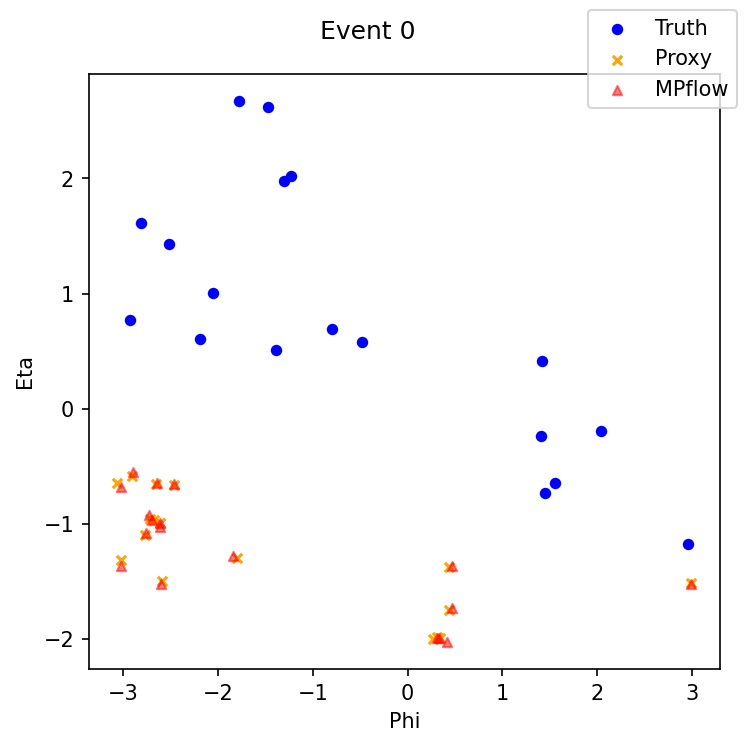

In [34]:
plot_matched_event(0)

In [12]:
file = uproot.open("/share/gpu1/syw24/dmitrii_clic/train_clic_fix.root")
print(file.keys())
events = file["EventTree;1"]

['EventTree;1']


In [11]:
events.show(name_width=100, typename_width=50)

name                                                                                                 | typename                                           | interpretation                
-----------------------------------------------------------------------------------------------------+----------------------------------------------------+-------------------------------
ntopo                                                                                                | int32_t                                            | AsDtype('>i4')
topo_x                                                                                               | float[]                                            | AsJagged(AsDtype('>f4'))
topo_y                                                                                               | float[]                                            | AsJagged(AsDtype('>f4'))
topo_z                                                                                       

In [15]:
events["nparticle"].arrays()

<Array [{nparticle: 25}, {...}, ..., {...}] type='1004891 * {nparticle: int32}'>